In [1]:
import numpy as np
import pandas as pd
import glob
import time
from scipy import signal
from tqdm.notebook import tqdm

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc

import matplotlib.pyplot as plt                         
import matplotlib.patches as patches

import random

In [2]:
channels = ['Fz', 'FCz', 'Cz', 'CPz', 'Pz', 'POz']

train_filtered = np.load('data/X_train_bwbs.npy')

f = 'data/TrainLabels.csv'
train_labels = pd.read_csv(f)
train_labels = train_labels.Prediction.values

In [3]:
# Silence warning messages 
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [4]:
#Using SVM to find the optimal C in the dataset with baseline
# LDA SVM
C_list = [0.001,0.01,0.1,10]

opt_C = None
scaler = StandardScaler()
best_Cs = []

start = time.time()

for i in range(len(train_filtered[0])):
    x_train, x_test, y_train, y_test = train_test_split(train_filtered[:,i,:], train_labels, test_size=0.2)
    auc_best=0
    for c in C_list:
#         estimator = SVC(kernel = 'linear', max_iter=10000, probability=True, C = c)
#         parameter = {'kernel':('linear',), 'C':[c]}
#         grid_search = GridSearchCV(estimator, parameter, cv=5)
#         grid_search.fit(scaler.fit_transform(x_train), y_train)
#         pred_y = grid_search.predict(scaler.transform(x_test))
#         auc_score = roc_auc_score(y_test, pred_y)
        clf = make_pipeline(StandardScaler(), SVC(kernel = 'linear', max_iter=10000, probability=True, C = c))
        clf.fit(x_train, y_train)
        pred_y = clf.predict(x_test)
        auc_score = roc_auc_score(y_test, pred_y)
#         print('AUC:'+"{0:.3f}".format(auc_score))
        if auc_score > auc_best:
            auc_best = auc_score
            opt_C = c
    best_Cs.append(opt_C)

print('Time taken: {}'.format(time.time() - start))
for i in range(len(channels)):
    print('Best parameter C* for {} = {}'.format(channels[i], best_Cs[i]))

Time taken: 121.1022138595581
Best parameter C* for Fz = 10
Best parameter C* for FCz = 10
Best parameter C* for Cz = 10
Best parameter C* for CPz = 0.001
Best parameter C* for Pz = 0.001
Best parameter C* for POz = 0.001


In [5]:
c_values = best_Cs # from prev cell
start = time.time()

for i in range(len(c_values)):
    x_train, x_test, y_train, y_test = train_test_split(train_filtered[:,i,:], train_labels, test_size=0.2)
    estimator = SVC(kernel = 'linear', max_iter=10000, probability=True)
    parameter = {'kernel':('linear',), 'C':[c_values[i]]}
    grid_search = GridSearchCV(estimator, parameter, cv=5)
    grid_search.fit(scaler.fit_transform(x_train), y_train)
    pred_y = grid_search.predict(scaler.transform(x_test))
    auc_score = roc_auc_score(y_test, pred_y)
    print('{} electrode score: {}'.format(channels[i], auc_score))

Fz electrode score: 0.5201708710378646
FCz electrode score: 0.523473249136966
Cz electrode score: 0.5053778182135424
CPz electrode score: 0.5
Pz electrode score: 0.5
POz electrode score: 0.5


In [6]:
# Fz electrode score: 0.497228405312354
# FCz electrode score: 0.5
# Cz electrode score: 0.5143310307070512
# CPz electrode score: 0.5053572310275021
# Pz electrode score: 0.5
# POz electrode score: 0.5107897013488649


for i in range(len(c_values)):
    x_train, x_test, y_train, y_test = train_test_split(train_filtered[:,i,:], train_labels, test_size=0.2)
    pred_y = [random.randint(0, 1) for i in range(len(y_test))]
    auc_score = roc_auc_score(y_test, pred_y)
    print('{} electrode score: {}'.format(channels[i], auc_score))

Fz electrode score: 0.5138542757603608
FCz electrode score: 0.4791979244811203
Cz electrode score: 0.5021546909714184
CPz electrode score: 0.5026616730853031
Pz electrode score: 0.5190721228457078
POz electrode score: 0.4807685688717561


In [15]:
# Train our classifier
clfs = []
for i in range(len(c_values)):
    x_train, x_test, y_train, y_test = train_test_split(train_filtered[:,i,:], train_labels, test_size=0.2)
    clf_lsqrs = LinearDiscriminantAnalysis(solver = 'lsqr',  shrinkage = 'auto').fit(x_train, y_train)
    clfs.append(clf_lsqrs)
    # Let's do 5-fold cross validation
    score_lsqrs = cross_val_score(clf_lsqrs.fit(x_train, y_train), x_train, y_train, cv = 5)

    # We will print out the mean score
    print("solver = lsqr  accuracy: %f" % np.mean(score_lsqrs))

NotImplementedError: shrinkage not supported

In [ ]:
# Test using classifier


In [8]:
nfolds = 5;
cv = StratifiedKFold(n_splits = nfolds)
x_train, x_test, y_train, y_test = train_test_split(train_filtered[:,i,:], train_labels, test_size=0.2)
X = x_train
y = y_train
tprs_lsqrs = []
aucs_lsqrs = []
mean_fpr_lsqrs = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_lsqrs = clf_lsqrs.fit(X[train], y[train]).predict_proba(X[test])
    fpr_lsqrs, tpr_lsqrs, th_lsqrs = roc_curve(y[test], probas_lsqrs[:, 1])
    tprs_lsqrs.append(np.interp(mean_fpr_lsqrs, fpr_lsqrs, tpr_lsqrs))
    tprs_lsqrs[-1][0] = 0.0
    roc_auc_lsqrs = auc(fpr_lsqrs, tpr_lsqrs)
    aucs_lsqrs.append(roc_auc_lsqrs)
    i += 1

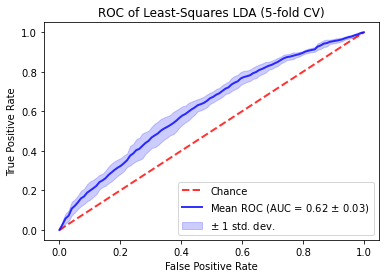

In [9]:
# Modified from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr_lsqrs = np.mean(tprs_lsqrs, axis=0)
mean_tpr_lsqrs[-1] = 1.0
mean_auc_lsqrs = auc(mean_fpr_lsqrs, mean_tpr_lsqrs)
std_auc_lsqrs = np.std(aucs_lsqrs);

plt.plot(mean_fpr_lsqrs, mean_tpr_lsqrs, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_lsqrs, std_auc_lsqrs),
         lw=2, alpha=.8)

std_tpr_lsqrs = np.std(tprs_lsqrs, axis=0)
tprs_upper_lsqrs = np.minimum(mean_tpr_lsqrs + std_tpr_lsqrs, 1)
tprs_lower_lsqrs = np.maximum(mean_tpr_lsqrs - std_tpr_lsqrs, 0)
plt.fill_between(mean_fpr_lsqrs, tprs_lower_lsqrs, tprs_upper_lsqrs, color='b', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Least-Squares LDA (' + str(nfolds) + '-fold CV)')
plt.legend(loc="lower right")
plt.show()

In [10]:
# Set clf to clf_lsqrs for convenience
clf = clf_lsqrs.fit(x_train, y)

# Make predictions on our dataset 
conf = clf.decision_function(x_test) # predicted confidence score
pred = clf.predict(x_test)           # predicted label (we won't actually use this)

auc_score = roc_auc_score(y_test, pred)
print(auc_score)

0.49867875914665566


In [11]:
# CONSTANTS
training_subjects = 16 #num of training subjects
num_of_fb = 340 #num of feedbacks / subject
freq = 200 #sampling rate
epoch_time = 0.5 #proposed epoching time in seconds
epoch = int(freq * epoch_time) #epoch in indices
pre_fb_time = 0.1
pre_fb = int(freq * pre_fb_time) #sampling time before the feedback
num_of_cols = 59
eeg_cols = 6
b_s = int(-0.4*freq) #index where baseline starts relative to feedback (-400ms)
b_e = int(-0.3*freq) #index where baseline ends relative to feedback (-300ms)
order = 2 #butterworth order
low_pass = 0.1 #low frequency pass for butterworth filter
high_pass = 20. #high frequency pass for butterworth filter

all_channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
               'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
               'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
               'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
               'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
               'PO7', 'POz', 'P08', 'O1', 'O2']
channels = ['Fz', 'FCz', 'Cz', 'CPz', 'Pz', 'POz']
# [10, 19, 28, 37, 46, 52]
channels_indices = []
for channel in channels:
    channels_indices.append(all_channels.index(channel))

In [13]:
def butter_filter(order, low_pass, high_pass, fs,sig):
    nyq = 0.5 * fs
#     lp = low_pass / nyq
#     hp = high_pass / nyq
    lp = low_pass
    hp = high_pass
    coeffs = [lp, hp]
    btype = 'bandpass'
    sos = signal.butter(order, [lp, hp], btype=btype, output = 'sos', fs = 200)
    return signal.sosfiltfilt(sos, sig, axis=0)
#     b = signal.firwin(numtaps=111, cutoff=coeffs, pass_zero=btype, fs=200) # order = odd number (31 - 201)
#     a = 1
#     filt = signal.filtfilt(b, a, sig, axis=0)
#     return filt



def extract_data(files, e_s = None, baseline = True, bandpass = True):
    start = time.time()
    
    dfs = []
    enum_files = list(enumerate(files))
    for i, f in tqdm(enum_files):
        df = pd.read_csv(f) #read each file
        index_fb = df[df['FeedBackEvent'] == 1].index.values
        df_array = np.array(df) 
        
        #uncomment below for butterworth filter
        if bandpass == True:
            eeg = df_array[:, channels_indices] #only eeg values to apply butterworth filter
            for i, channel in enumerate(channels):
                raw_eeg = df[channel].values
                eeg_filtered = butter_filter(order, low_pass, high_pass, freq, raw_eeg) #butterworth filter applied
                eeg[:,i] = eeg_filtered
            df = np.array(df)
            df[:, channels_indices] = eeg #replacing old eeg values with new ones
        
        df = df[:, channels_indices]
        
#         for j, indx in enumerate(index_fb): #epoching 100 indexes (0.5 seconds) after each stimulus
#             epoch_array = df[indx-pre_fb:indx+epoch, :]
#             epoch_array = epoch_array.reshape((1, epoch_array.shape[0], epoch_array.shape[1]))

        #uncomment below for baseline correction
        if baseline == True:
            #baseline correction of 100ms (20 indexes), 400ms to 300ms before fb
            baseline_array = df[indx+b_s:indx+b_e, :] 
            baseline_array = baseline_array.reshape((1,20,int(baseline_array.shape[1])))
            baseline_mean = np.mean(baseline_array, axis = 1)
            #noise subtracted from epoched data
            epoch_array[:,:,:] = epoch_array[:,:,:] - baseline_mean
        
        df = pd.DataFrame(df, columns=channels)
        dfs.append(df)
    
    res = pd.concat(dfs).to_numpy()
    now = time.time()
    print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
    return res

In [14]:
train_files = glob.glob('data/Train/Data*.csv')
train = extract_data(train_files) # 80 iterations
print(train.shape)
np.save('tr1_model.npy',train[1:,:])

train = np.load('tr1_model.npy')

  0%|          | 0/80 [00:00<?, ?it/s]

NameError: name 'indx' is not defined